In [1]:
# KHOÁ LUẬN TỐT NGHIỆP - MODELS - PHẦN 2
# Họ và tên: Lại Minh Phú - MSSV: 20127593
# Họ và tên: Hồ Minh Thanh Tài - MSSV: 20127068

In [2]:
%pip install imblearn
%pip install lightgbm
%pip install xgboost
%pip install catboost
%pip install --quiet optuna

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [56]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.decomposition import PCA
from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn import datasets, linear_model, metrics
from imblearn.over_sampling import SMOTE

# Thự viên các mô hình sử dụng
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import lightgbm as lgb
import xgboost as xgb
import catboost as cb


%matplotlib inline
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_curve, precision_recall_curve, auc, ConfusionMatrixDisplay

# Các thư viện khác
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
import collections
from collections import Counter
import warnings
warnings.filterwarnings("ignore")


In [4]:
df = pd.read_csv("creditcard.csv")
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [5]:
# 284315 Not-Fraud, 492 Fraud
df["Class"].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [6]:
x = df.drop(['Class','Time'], axis=1)

y = df['Class']

## Spilt thành tập train và tập test

In [7]:
seed = 42

# Split the data into train, test, and validation sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = seed)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((227845, 29), (56962, 29), (227845,), (56962,))

## Scale 

In [8]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
X_train

array([[ 8.66514037e-01, -3.18740903e-01, -2.57831791e-01, ...,
         2.69826619e-01, -4.45139004e-01, -1.67972028e-01],
       [-1.87412161e-01, -4.94335107e-01,  7.18249023e-01, ...,
        -2.29014575e+00, -1.18801493e+00,  3.34265734e-01],
       [ 2.43934573e-02,  5.38221071e-01, -3.86388287e-01, ...,
         1.26284605e+00,  4.48261891e-01, -1.40000000e-01],
       ...,
       [-7.36254539e-02,  6.61185829e-01,  7.02202848e-01, ...,
        -7.54486386e-01, -1.57908244e+00, -2.52587413e-01],
       [-1.32706845e+00,  1.63267692e+00, -1.40917571e+00, ...,
         3.05218623e+00,  2.46838464e+00, -2.93706294e-01],
       [ 5.43598556e-01, -6.06975975e-01,  1.08415011e-01, ...,
        -8.78479616e-04,  2.07096240e-01,  1.27272727e+00]])

In [10]:
X_test

array([[-7.40091104e+00,  6.07683172e+00, -9.82623873e+00, ...,
        -1.24410856e+01, -8.01989481e+00,  4.78587413e+00],
       [ 1.43967206e-01, -2.00432112e+00, -1.63402851e-01, ...,
         2.44127890e-01,  6.89809266e-01,  6.96671329e+00],
       [ 6.18042059e-01, -4.68482847e-01, -5.43876581e-03, ...,
         6.18960568e-02, -5.12163588e-02,  1.25874126e-01],
       ...,
       [ 1.00485653e-02, -1.25394779e-01, -7.54347971e-01, ...,
         2.19564896e+00,  2.60956835e+00, -2.00979021e-01],
       [-2.29493924e-01,  6.60140661e-01,  7.78913926e-01, ...,
         2.41254081e-01, -2.13886375e+00, -2.57482517e-01],
       [-7.19520654e-01,  6.60807294e-01, -3.61072611e-01, ...,
         7.66141087e-01, -4.70610893e+00,  1.23679720e+01]])

## SMOTE

In [11]:
print('Kích thước tập dữ liệu trước SMOTE %s' % Counter(y_train))

smt = SMOTE(random_state=42)
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)

print('Kích thước tập dữ liệu trước SMOTE %s' % Counter(y_train_smt))

Kích thước tập dữ liệu trước SMOTE Counter({0: 227451, 1: 394})
Kích thước tập dữ liệu trước SMOTE Counter({0: 227451, 1: 227451})


### Biểu diễn đồ thị ROC-AUC

In [12]:
def plot_roc_cur(FPR, TPR):  
    plt.plot(FPR, TPR, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

### Biểu diễn đồ thị PR-AUC

In [13]:
def plot_pr_cur(precision, recall, pr_auc):
    plt.plot(recall, precision, color='orange', label=f'PR AUC = {pr_auc:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

### Hàm chạy mô hình

In [14]:
def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    t0=time.time()
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)
    
    y_pred = model.predict(X_test)
    
    print(classification_report(y_test,y_pred, digits =5))
    
#   precision = precision_score(y_test, y_pred) 
#   recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)
    
    time_taken = time.time()-t0
    
#    print(f"Precision = \t {precision_score(y_test, y_pred):.5f}")
    print(f"Recall = \t {recall_score(y_test, y_pred):.5f}")
    print("F1 Score  = {}".format(f1))
    print("Accuracy = {}".format(accuracy))
    print("ROC Area under Curve = {}".format(roc_auc))
    print("Area under Precision-Recall Curve = {}".format(pr_auc))
    print("Time taken = {}".format(time_taken))
     
    
    probs = model.predict_proba(X_test)  
    probs = probs[:, 1]  
    FPR, TPR, thresholds = roc_curve(y_test, probs) 
    plot_roc_cur(FPR, TPR)
    plot_pr_cur(precision, recall, pr_auc)
    
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    
    return model, recall_score(y_test, y_pred), f1, accuracy, roc_auc, pr_auc, time_taken

# SUPERVISED (SVC, LightGBM, KNN, LogisticRegression, RandomForest, XGBoost, CatBoost)

## LightGBM 

[LightGBM] [Info] Number of positive: 394, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001729 -> initscore=-6.358339
[LightGBM] [Info] Start training from score -6.358339
              precision    recall  f1-score   support

           0    0.99884   0.99752   0.99818     56864
           1    0.18497   0.32653   0.23616        98

    accuracy                        0.99637     56962
   macro avg    0.59190   0.66203   0.61717     56962
weighted avg    0.99744   0.99637   0.99687     56962

Recall = 	 0.32653
F1 Score  = 0.23616236162361623
Accuracy = 0.9963659983848882
ROC Area under Curve = 0.6620255058973505
Area under Precision-Recall Curve = 0.2563301888462119
T

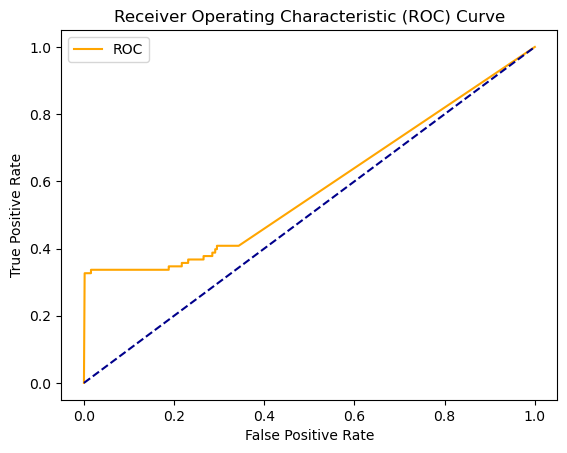

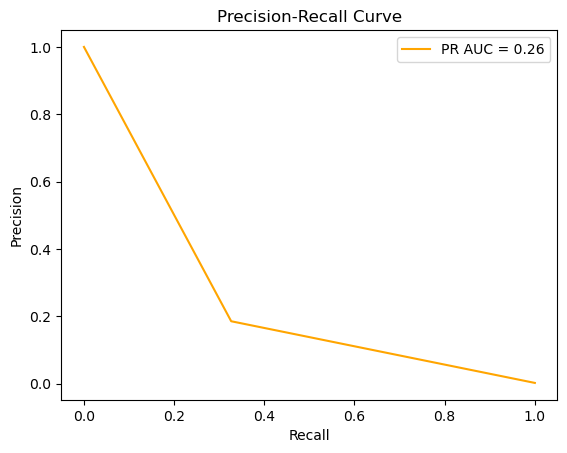

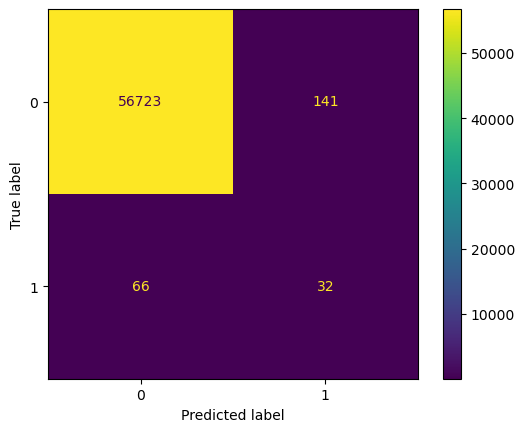

In [15]:
model_lgb = lgb.LGBMClassifier()

model_lgb, recall_lgb, f1_score_lgb, accuracy_lgb, roc_auc_lgb, pr_auc_lgb, tt_lgb = run_model(model_lgb, X_train, y_train, X_test, y_test)

In [16]:
print(recall_lgb)

0.32653061224489793


## LightGBM + SMOTE

[LightGBM] [Info] Number of positive: 227451, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.226273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 454902, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
              precision    recall  f1-score   support

           0    0.99979   0.99884   0.99931     56864
           1    0.56579   0.87755   0.68800        98

    accuracy                        0.99863     56962
   macro avg    0.78279   0.93820   0.84366     56962
weighted avg    0.99904   0.99863   0.99878     56962

Recall = 	 0.87755
F1 Score  = 0.688
Accuracy = 0.9986306660580738
ROC Area under Curve = 0.9381951781838227
Area under Precision-Recall Curve = 0.7217755804263352
Time taken = 53.691176891326904


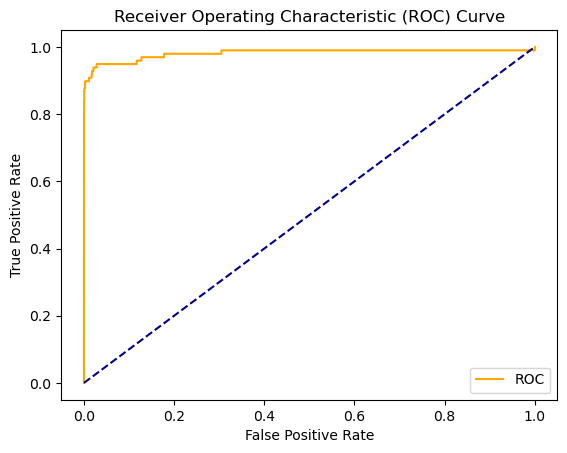

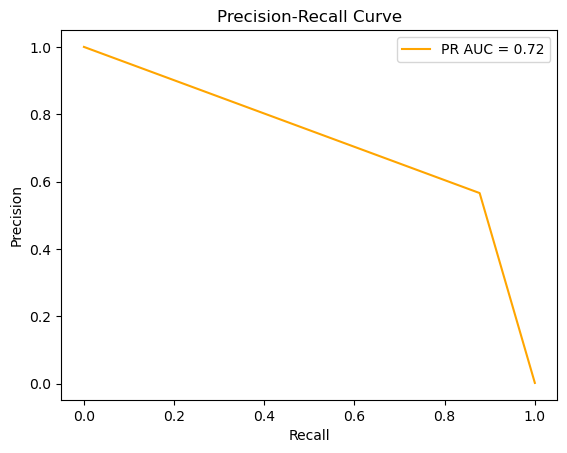

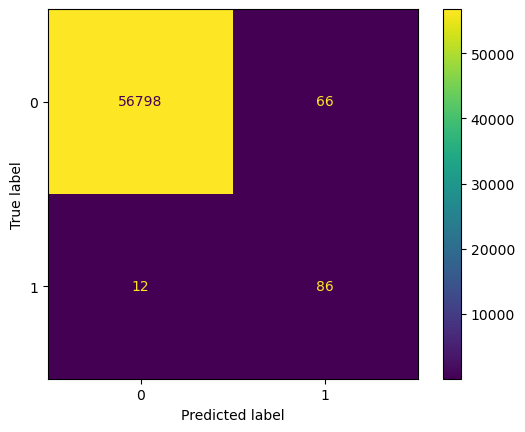

In [17]:
model_lgbsmt, recall_lgbsmt, f1_score_lgbsmt, accuracy_lgbsmt, roc_auc_lgbsmt, pr_auc_lgbsmt, tt_lgbsmt= run_model(model_lgb, X_train_smt, y_train_smt, X_test, y_test)

## KNN

              precision    recall  f1-score   support

           0    0.99956   0.99995   0.99975     56864
           1    0.96053   0.74490   0.83908        98

    accuracy                        0.99951     56962
   macro avg    0.98004   0.87242   0.91942     56962
weighted avg    0.99949   0.99951   0.99948     56962

Recall = 	 0.74490
F1 Score  = 0.8390804597701149
Accuracy = 0.9995084442259752
ROC Area under Curve = 0.8724226008636431
Area under Precision-Recall Curve = 0.8529315820285489
Time taken = 126.38553738594055


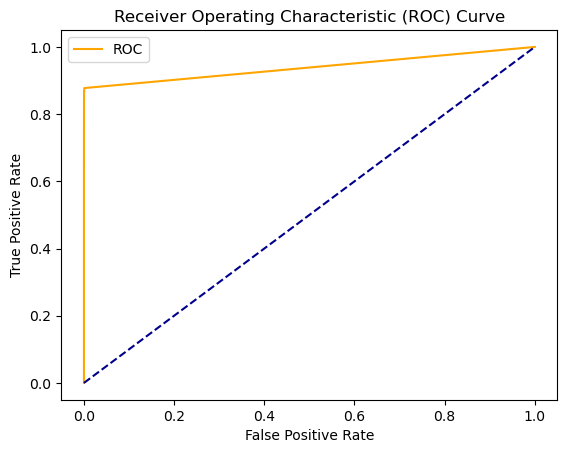

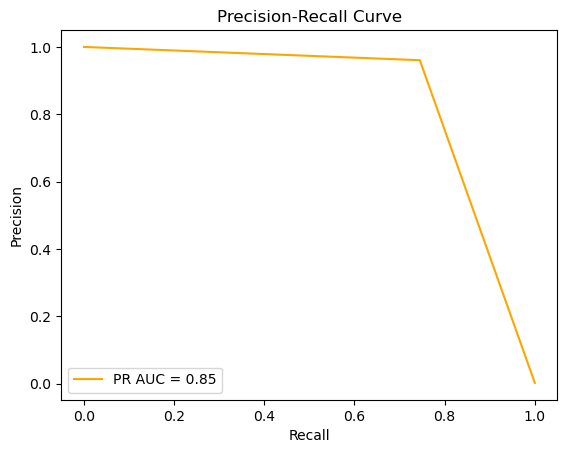

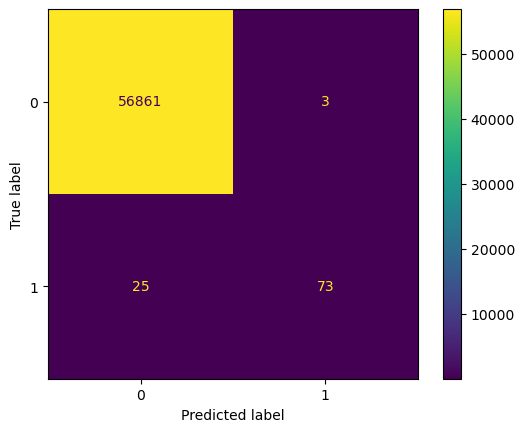

In [18]:
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)

knn_clf, recall_knn, f1_score_knn, accuracy_knn, roc_auc_knn, pr_auc_knn, tt_knn = run_model(knn_clf, X_train, y_train, X_test, y_test)

## KNN +SMOTE

              precision    recall  f1-score   support

           0    0.99975   0.99852   0.99914     56864
           1    0.50000   0.85714   0.63158        98

    accuracy                        0.99828     56962
   macro avg    0.74988   0.92783   0.81536     56962
weighted avg    0.99889   0.99828   0.99851     56962

Recall = 	 0.85714
F1 Score  = 0.631578947368421
Accuracy = 0.9982795547909132
ROC Area under Curve = 0.9278328241820083
Area under Precision-Recall Curve = 0.6786943175149347
Time taken = 164.25271153450012


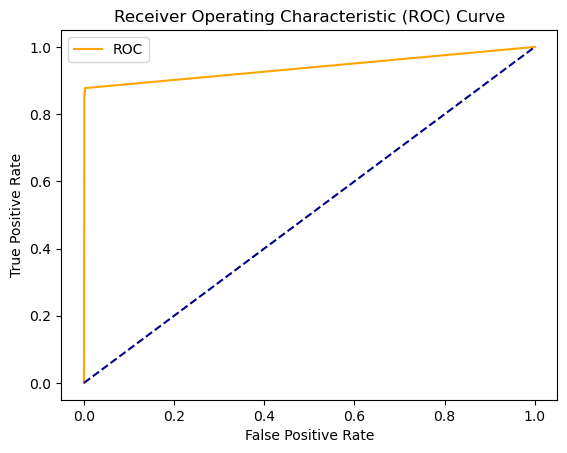

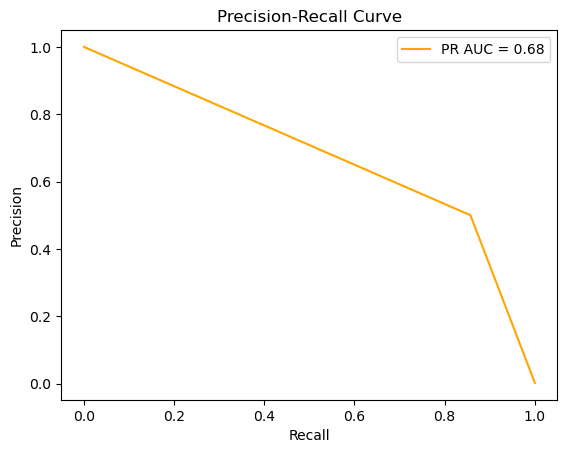

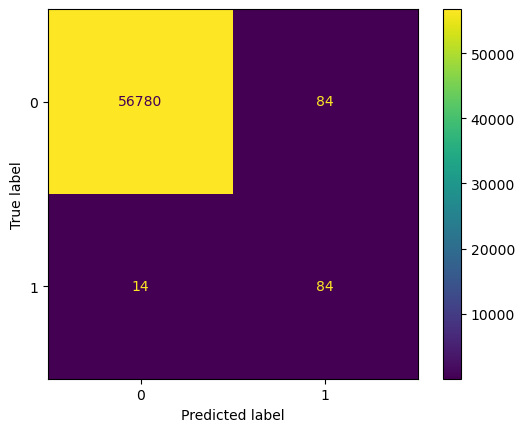

In [33]:
knnsmt_clf, recall_knnsmt, f1_score_knnsmt, accuracy_knnsmt, roc_auc_knnsmt, pr_auc_knnsmt, tt_knnsmt = run_model(knn_clf, X_train_smt, y_train_smt, X_test, y_test)

## LogisticRegression

              precision    recall  f1-score   support

           0    0.99928   0.99984   0.99956     56864
           1    0.86364   0.58163   0.69512        98

    accuracy                        0.99912     56962
   macro avg    0.93146   0.79074   0.84734     56962
weighted avg    0.99905   0.99912   0.99904     56962

Recall = 	 0.58163
F1 Score  = 0.6951219512195121
Accuracy = 0.9991222218320986
ROC Area under Curve = 0.7907371903460314
Area under Precision-Recall Curve = 0.7229943973976337
Time taken = 19.101892948150635


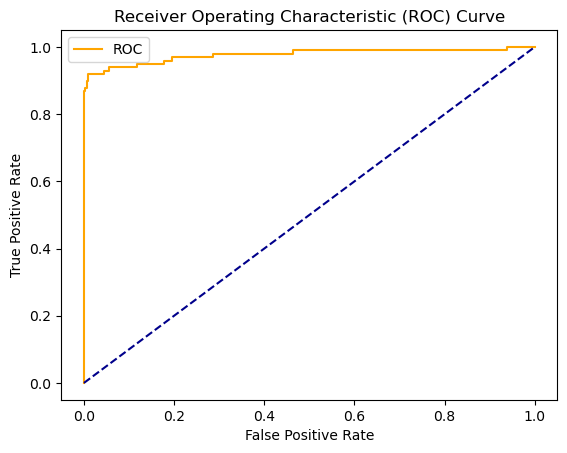

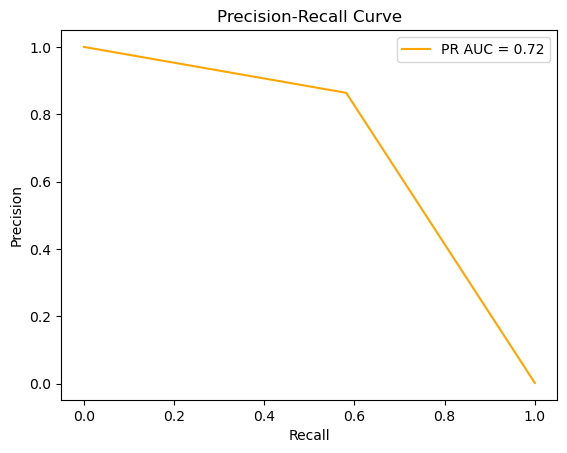

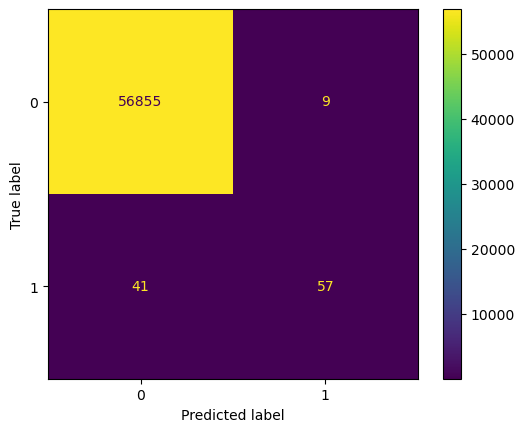

In [34]:
params_lr = {'penalty': 'l1', 'solver':'liblinear'}

model_lr = LogisticRegression(**params_lr)

model_lr, recall_lr, f1_score_lr,accuracy_lr, roc_auc_lr, pr_auc_lr, tt_lr = run_model(model_lr, X_train, y_train, X_test, y_test)
     

## LogisticRegression + SMOTE

              precision    recall  f1-score   support

           0    0.99986   0.97341   0.98646     56864
           1    0.05618   0.91837   0.10588        98

    accuracy                        0.97332     56962
   macro avg    0.52802   0.94589   0.54617     56962
weighted avg    0.99823   0.97332   0.98494     56962

Recall = 	 0.91837
F1 Score  = 0.10588235294117647
Accuracy = 0.9733155436957972
ROC Area under Curve = 0.945888794459821
Area under Precision-Recall Curve = 0.4873437833632693
Time taken = 34.95974802970886


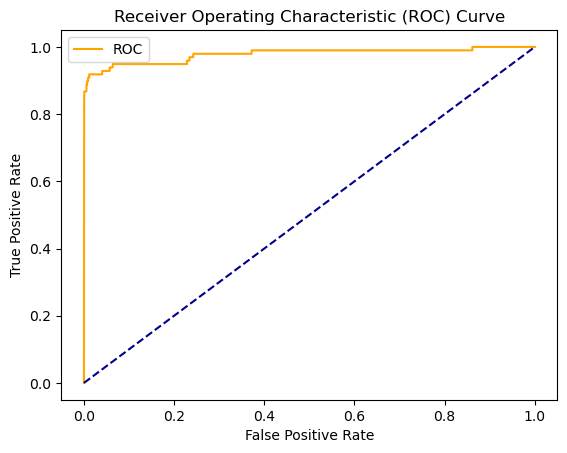

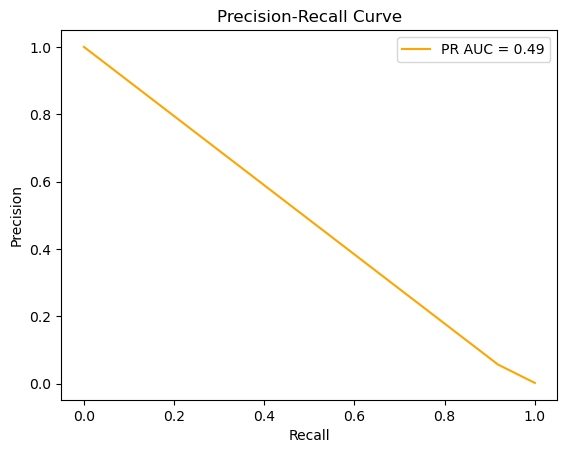

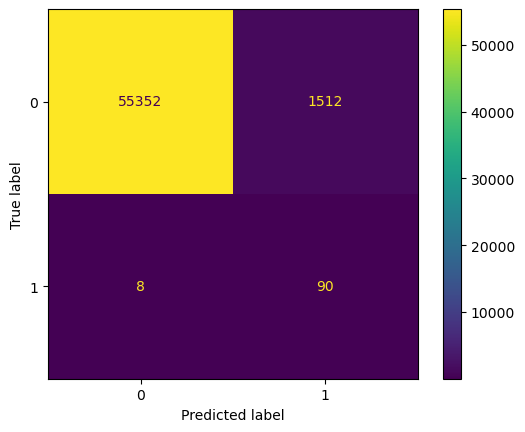

In [35]:
model_lrsmt, recall_lrsmt, f1_score_lrsmt,accuracy_lrsmt, roc_auc_lrsmt, pr_auc_lrsmt, tt_lrsmt = run_model(model_lr, X_train_smt, y_train_smt, X_test, y_test)

## RandomForest

              precision    recall  f1-score   support

           0    0.99961   0.99996   0.99979     56864
           1    0.97436   0.77551   0.86364        98

    accuracy                        0.99958     56962
   macro avg    0.98699   0.88774   0.93171     56962
weighted avg    0.99957   0.99958   0.99955     56962

Recall = 	 0.77551
F1 Score  = 0.8636363636363636
Accuracy = 0.9995786664794073
ROC Area under Curve = 0.8877375162220206
Area under Precision-Recall Curve = 0.8751277004172419
Time taken = 490.4159631729126


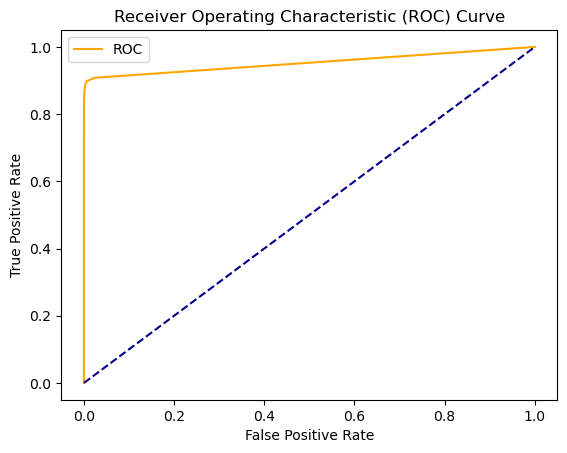

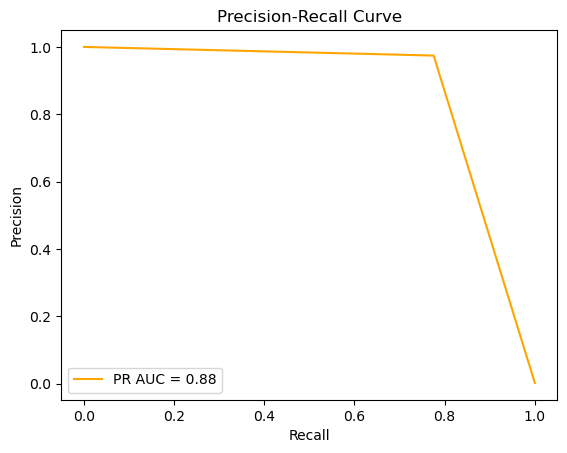

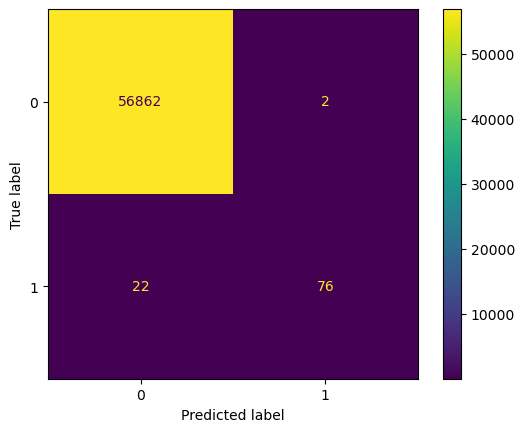

In [36]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier()
model_rf, recall_rf, f1_score_rf,accuracy_rf, roc_auc_rf, pr_auc_rf, tt_rf = run_model(model_rf, X_train, y_train, X_test, y_test)
     

## RandomForest + SMOTE

              precision    recall  f1-score   support

           0    0.99972   0.99982   0.99977     56864
           1    0.89130   0.83673   0.86316        98

    accuracy                        0.99954     56962
   macro avg    0.94551   0.91828   0.93146     56962
weighted avg    0.99953   0.99954   0.99954     56962

Recall = 	 0.83673
F1 Score  = 0.8631578947368421
Accuracy = 0.9995435553526912
ROC Area under Curve = 0.9182794178447969
Area under Precision-Recall Curve = 0.8641599653586832
Time taken = 972.4563956260681


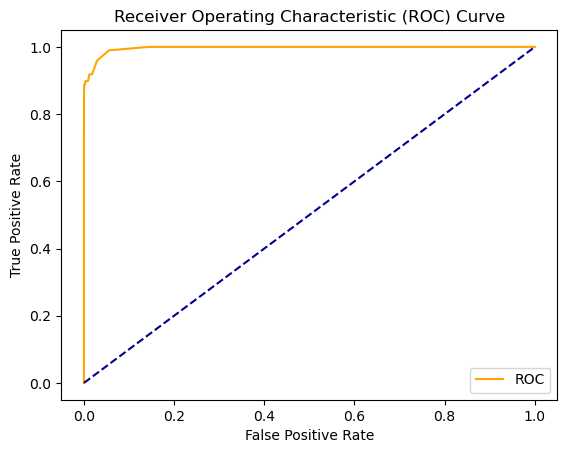

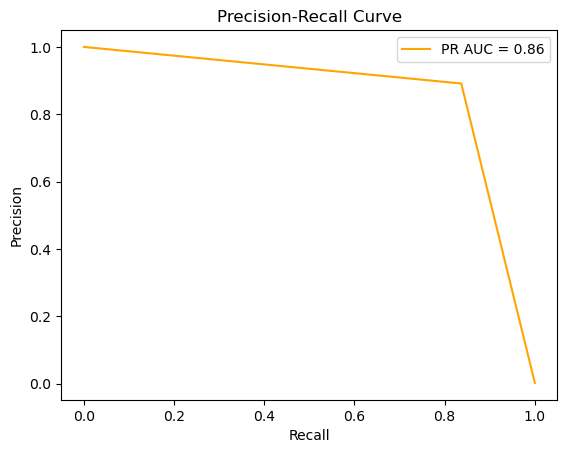

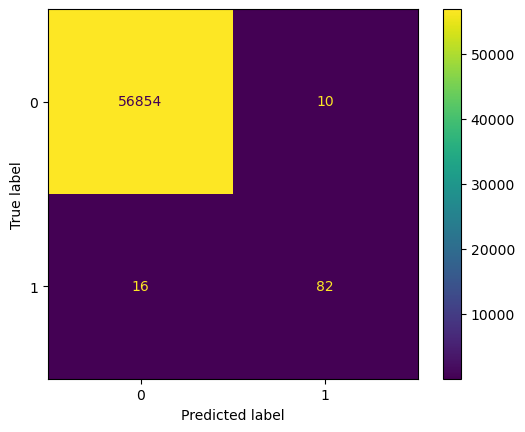

In [37]:
model_rfsmt, recall_rfsmt, f1_score_rfsmt, accuracy_rfsmt, roc_auc_rfsmt, pr_auc_rfsmt, tt_rfsmt = run_model(model_rf, X_train_smt, y_train_smt, X_test, y_test)
     

### DecisionTree 

              precision    recall  f1-score   support

           0    0.99956   0.99968   0.99962     56864
           1    0.80220   0.74490   0.77249        98

    accuracy                        0.99925     56962
   macro avg    0.90088   0.87229   0.88605     56962
weighted avg    0.99922   0.99925   0.99923     56962

Recall = 	 0.74490
F1 Score  = 0.7724867724867724
Accuracy = 0.9992451107756047
ROC Area under Curve = 0.8722907072226753
Area under Precision-Recall Curve = 0.7737673252327133
Time taken = 8.273128032684326


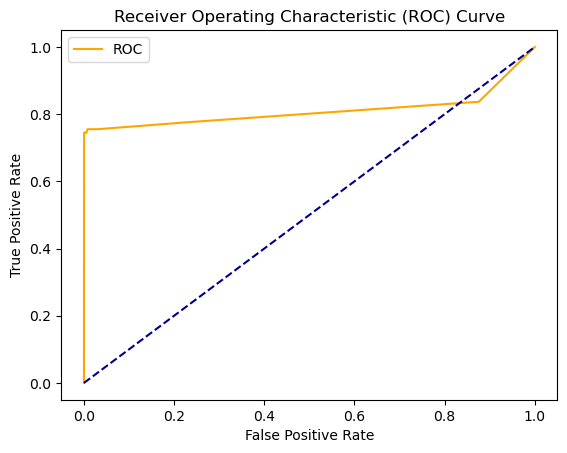

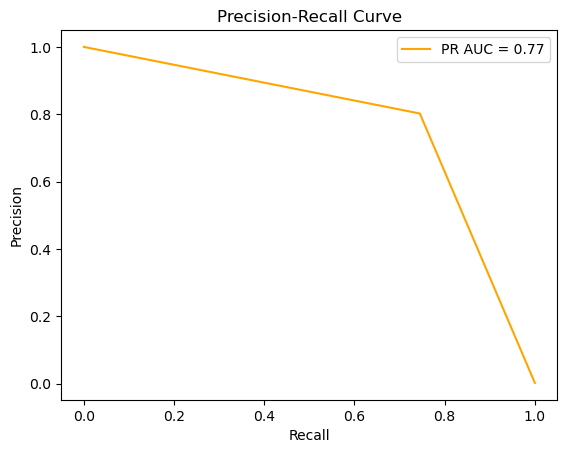

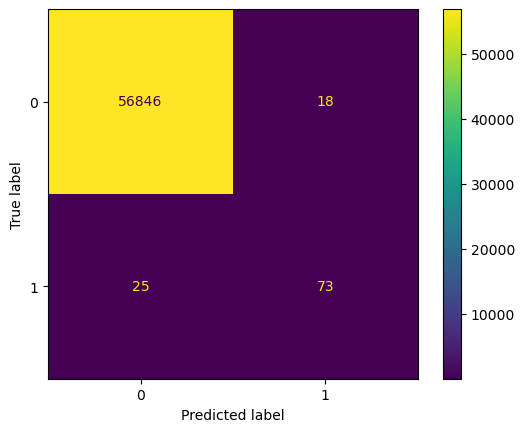

In [38]:
from sklearn.tree import DecisionTreeClassifier
params_dt = {'max_depth': 16,
             'max_features': "sqrt"}

model_dt = DecisionTreeClassifier(**params_dt)
model_dt, recall_dt, f1_score_dt, accuracy_dt, roc_auc_dt, pr_auc_dt, tt_dt = run_model(model_dt, X_train, y_train, X_test,y_test)

### DecisionTree + SMOTE

              precision    recall  f1-score   support

           0    0.99968   0.98908   0.99435     56864
           1    0.11412   0.81633   0.20025        98

    accuracy                        0.98878     56962
   macro avg    0.55690   0.90270   0.59730     56962
weighted avg    0.99816   0.98878   0.99299     56962

Recall = 	 0.81633
F1 Score  = 0.2002503128911139
Accuracy = 0.98878199501422
ROC Area under Curve = 0.9027028685700504
Area under Precision-Recall Curve = 0.4653826063178569
Time taken = 14.771502256393433


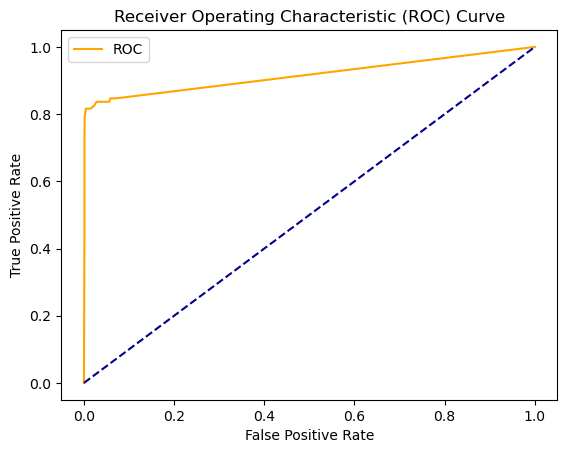

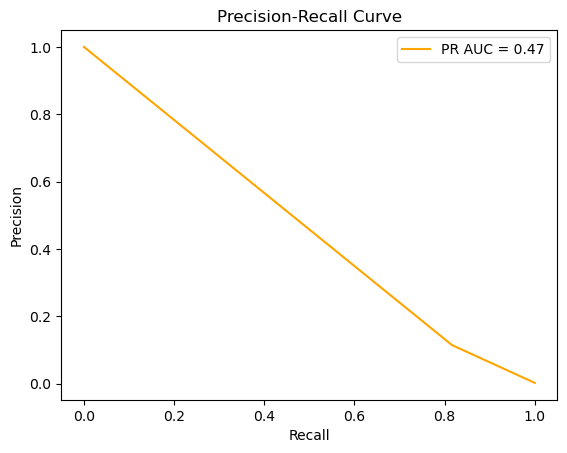

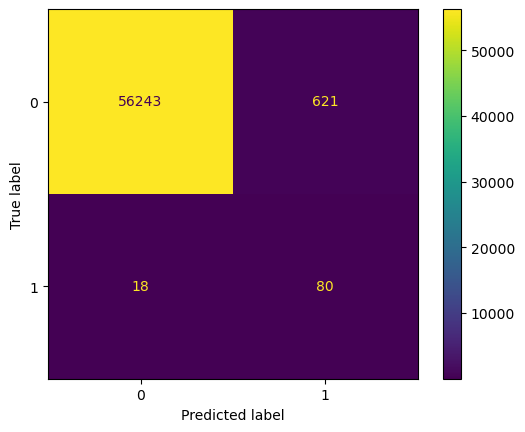

In [39]:
model_dtsmt, recall_dtsmt, f1_score_dtsmt, accuracy_dtsmt, roc_auc_dtsmt, pr_auc_dtsmt, tt_dtsmt = run_model(model_dt, X_train_smt, y_train_smt, X_test,y_test)

### XGBoost

              precision    recall  f1-score   support

           0    0.99960   0.99993   0.99976     56864
           1    0.94937   0.76531   0.84746        98

    accuracy                        0.99953     56962
   macro avg    0.97448   0.88262   0.92361     56962
weighted avg    0.99951   0.99953   0.99950     56962

Recall = 	 0.76531
F1 Score  = 0.847457627118644
Accuracy = 0.9995259997893332
ROC Area under Curve = 0.8826178895868984
Area under Precision-Recall Curve = 0.8575384945069046
Time taken = 3.6235744953155518


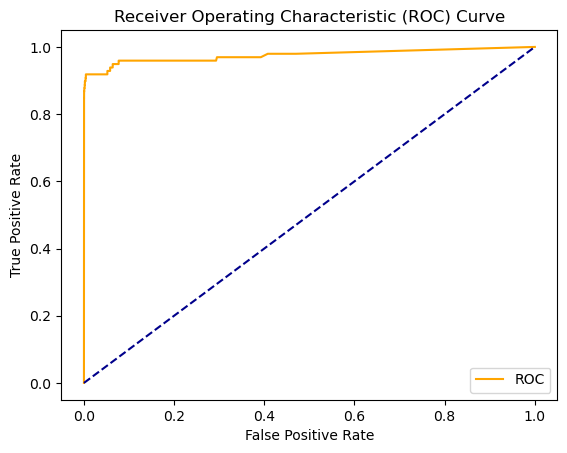

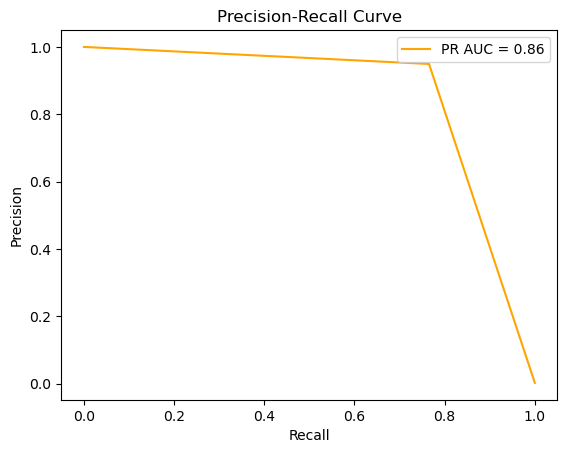

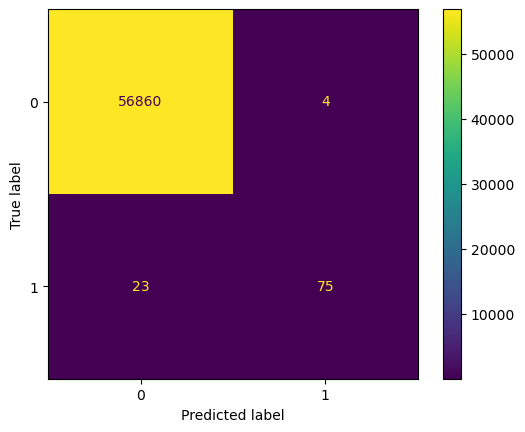

In [40]:
params_xgb ={'n_estimators': 20,
            'max_depth': 16}

model_xgb = xgb.XGBClassifier(**params_xgb)
model_xgb, recall_xgb, f1_score_xgb, accuracy_xgb, roc_auc_xgb, pr_auc_xgb, tt_xgb = run_model(model_xgb, X_train, y_train, X_test, y_test)
     

### XGBoost + SMOTE

              precision    recall  f1-score   support

           0    0.99972   0.99958   0.99965     56864
           1    0.77358   0.83673   0.80392        98

    accuracy                        0.99930     56962
   macro avg    0.88665   0.91816   0.90178     56962
weighted avg    0.99933   0.99930   0.99931     56962

Recall = 	 0.83673
F1 Score  = 0.803921568627451
Accuracy = 0.9992977774656788
ROC Area under Curve = 0.9181563171132269
Area under Precision-Recall Curve = 0.8053002442758285
Time taken = 12.815423011779785


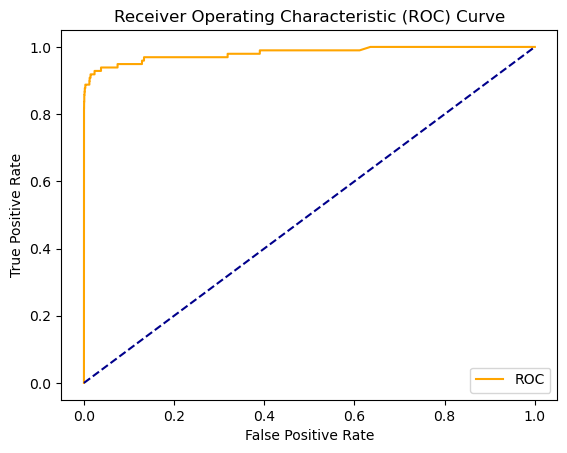

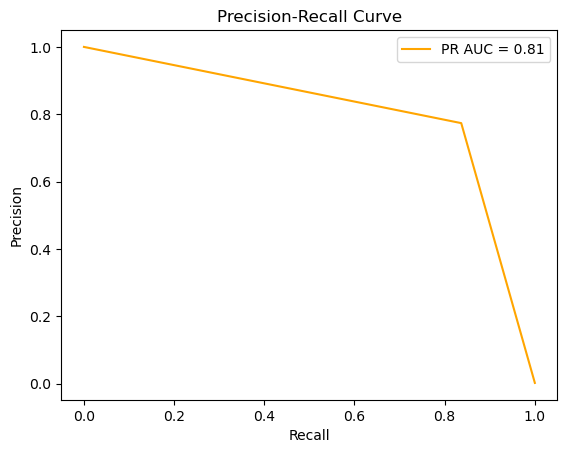

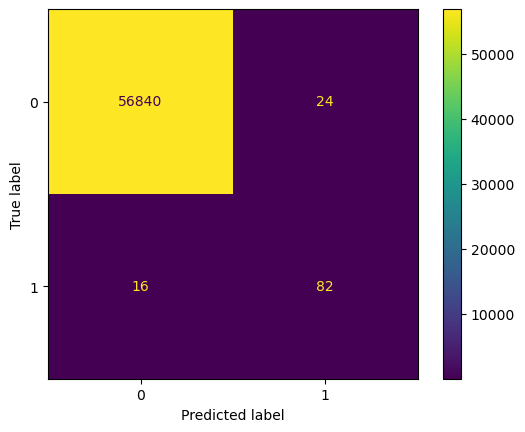

In [41]:
model_xgbsmt, recall_xgbsmt, f1_score_xgbsmt, accuracy_xgbsmt, roc_auc_xgbsmt, pr_auc_xgbsmt, tt_xgbsmt = run_model(model_xgb, X_train_smt, y_train_smt, X_test, y_test)


### CatBoost

Learning rate set to 0.5
0:	learn: 0.0369016	total: 20.6s	remaining: 6m 31s
1:	learn: 0.0080193	total: 39.5s	remaining: 5m 55s
2:	learn: 0.0046350	total: 57.6s	remaining: 5m 26s
3:	learn: 0.0035516	total: 1m 15s	remaining: 5m 2s
4:	learn: 0.0027589	total: 1m 33s	remaining: 4m 39s
5:	learn: 0.0022880	total: 1m 51s	remaining: 4m 19s
6:	learn: 0.0019234	total: 2m 9s	remaining: 4m
7:	learn: 0.0016353	total: 2m 27s	remaining: 3m 41s
8:	learn: 0.0014243	total: 2m 45s	remaining: 3m 22s
9:	learn: 0.0012724	total: 3m 4s	remaining: 3m 4s
10:	learn: 0.0010896	total: 3m 24s	remaining: 2m 47s
11:	learn: 0.0009375	total: 3m 43s	remaining: 2m 28s
12:	learn: 0.0008584	total: 4m 1s	remaining: 2m 9s
13:	learn: 0.0007711	total: 4m 19s	remaining: 1m 51s
14:	learn: 0.0006864	total: 4m 37s	remaining: 1m 32s
15:	learn: 0.0006189	total: 4m 55s	remaining: 1m 13s
16:	learn: 0.0005767	total: 5m 14s	remaining: 55.4s
17:	learn: 0.0005236	total: 5m 31s	remaining: 36.8s
18:	learn: 0.0004846	total: 5m 48s	remaining: 

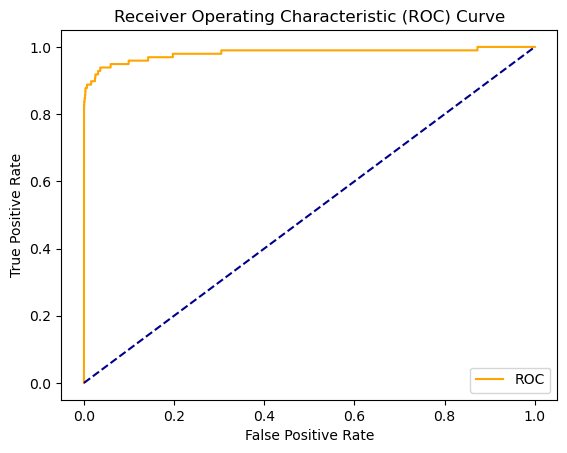

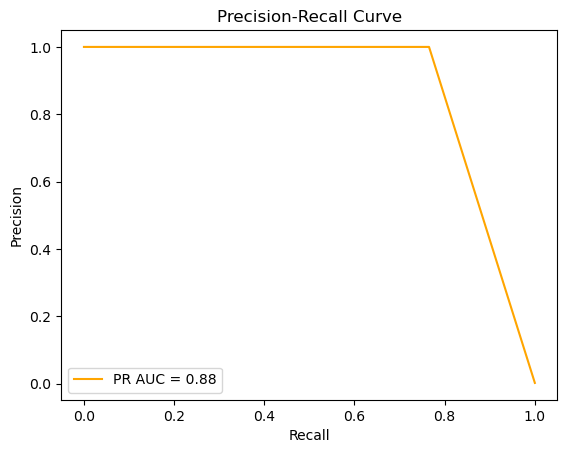

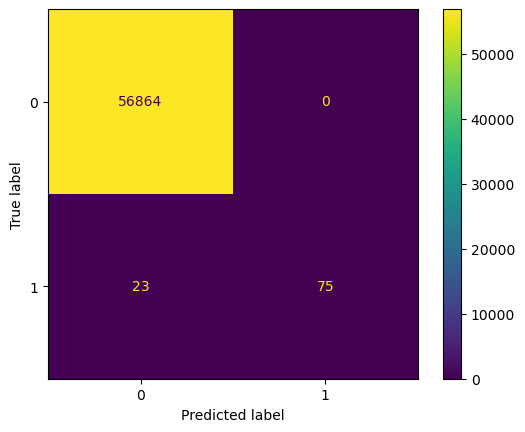

In [42]:
params_cb ={'iterations': 20,
            'max_depth': 16}

model_cb = cb.CatBoostClassifier(**params_cb)
model_cb, recall_cb, f1_score_cb, accuracy_cb, roc_auc_cb , pr_auc_cb, tt_cb = run_model(model_cb, X_train, y_train, X_test, y_test)

### CatBoost + SMOTE

Learning rate set to 0.5
0:	learn: 0.0975313	total: 21.8s	remaining: 6m 54s
1:	learn: 0.0363890	total: 41.5s	remaining: 6m 13s
2:	learn: 0.0194832	total: 1m 1s	remaining: 5m 47s
3:	learn: 0.0124032	total: 1m 20s	remaining: 5m 21s
4:	learn: 0.0083278	total: 1m 38s	remaining: 4m 55s
5:	learn: 0.0062779	total: 1m 56s	remaining: 4m 32s
6:	learn: 0.0048889	total: 2m 15s	remaining: 4m 12s
7:	learn: 0.0039155	total: 2m 34s	remaining: 3m 52s
8:	learn: 0.0029616	total: 2m 53s	remaining: 3m 31s
9:	learn: 0.0025822	total: 3m 12s	remaining: 3m 12s
10:	learn: 0.0021711	total: 3m 29s	remaining: 2m 51s
11:	learn: 0.0018193	total: 3m 48s	remaining: 2m 32s
12:	learn: 0.0016379	total: 4m 6s	remaining: 2m 12s
13:	learn: 0.0014651	total: 4m 25s	remaining: 1m 53s
14:	learn: 0.0013165	total: 4m 44s	remaining: 1m 34s
15:	learn: 0.0011150	total: 5m 3s	remaining: 1m 15s
16:	learn: 0.0009916	total: 5m 20s	remaining: 56.6s
17:	learn: 0.0009430	total: 5m 38s	remaining: 37.6s
18:	learn: 0.0008855	total: 5m 55s	rem

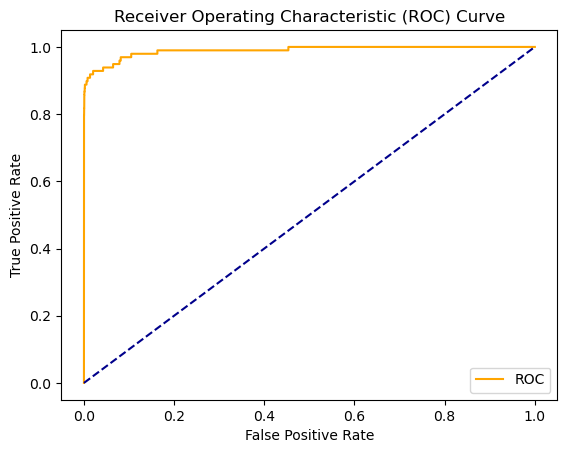

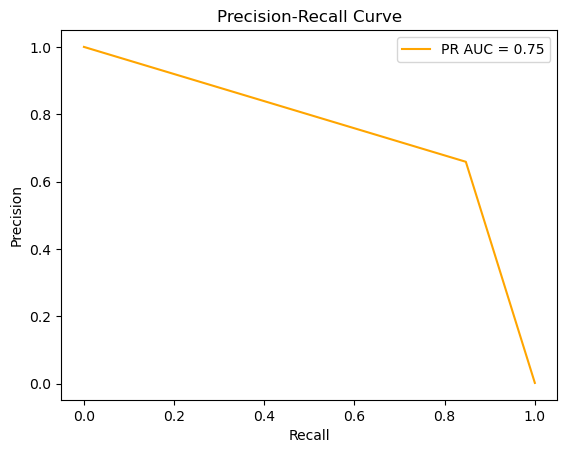

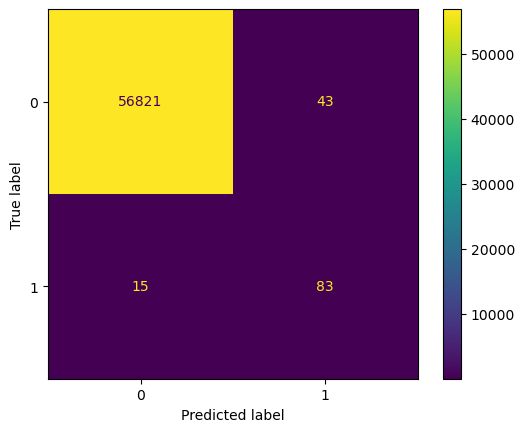

In [43]:
model_cbsmt, recall_cbsmt, f1_score_cbsmt, accuracy_cbsmt, roc_auc_cbsmt , pr_auc_cbsmt, tt_cbsmt= run_model(model_cb, X_train_smt, y_train_smt, X_test, y_test)

### Adaboost 

              precision    recall  f1-score   support

           0    0.99953   0.99986   0.99969     56864
           1    0.89873   0.72449   0.80226        98

    accuracy                        0.99939     56962
   macro avg    0.94913   0.86217   0.90098     56962
weighted avg    0.99935   0.99939   0.99935     56962

Recall = 	 0.72449
F1 Score  = 0.8022598870056498
Accuracy = 0.999385555282469
ROC Area under Curve = 0.8621745546840007
Area under Precision-Recall Curve = 0.8118489866721119
Time taken = 243.1895670890808


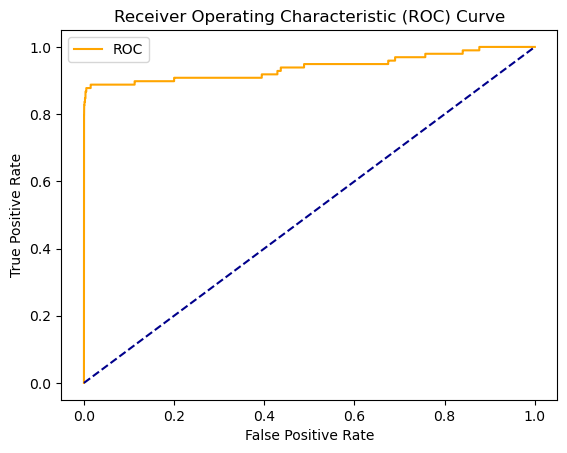

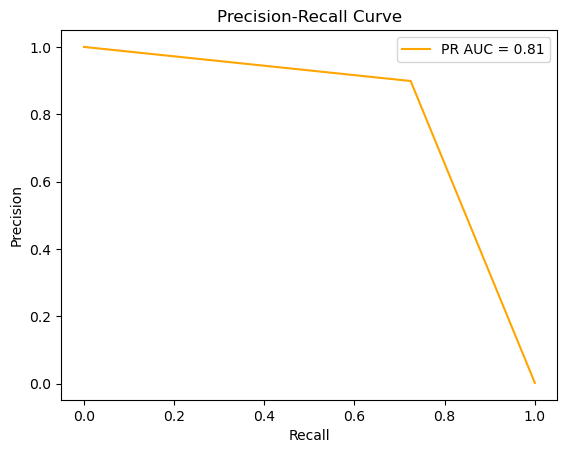

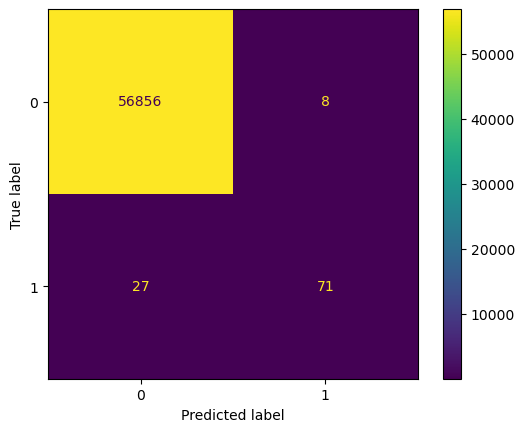

In [44]:
from sklearn.ensemble import AdaBoostClassifier
model_ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),
                                  n_estimators=50,
                                  algorithm="SAMME.R",
                                  learning_rate=0.5)
model_ada, recall_ada, f1_score_ada, accuracy_ada, roc_auc_ada, pr_auc_ada, tt_ada = run_model(model_ada, X_train, y_train, X_test, y_test)

### Adaboost + SMOTE

              precision    recall  f1-score   support

           0    0.99979   0.98876   0.99424     56864
           1    0.11862   0.87755   0.20899        98

    accuracy                        0.98857     56962
   macro avg    0.55920   0.93316   0.60162     56962
weighted avg    0.99827   0.98857   0.99289     56962

Recall = 	 0.87755
F1 Score  = 0.20899149453219928
Accuracy = 0.9885713282539237
ROC Area under Curve = 0.933156841098848
Area under Precision-Recall Curve = 0.49819118841181603
Time taken = 626.5590052604675


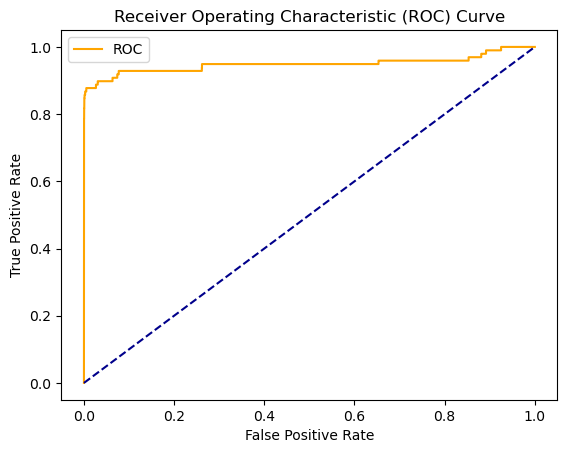

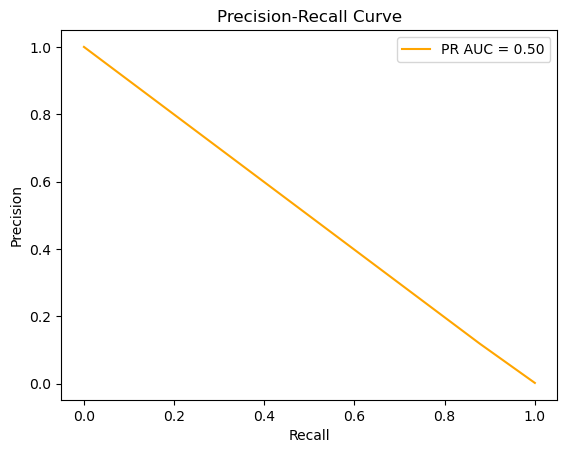

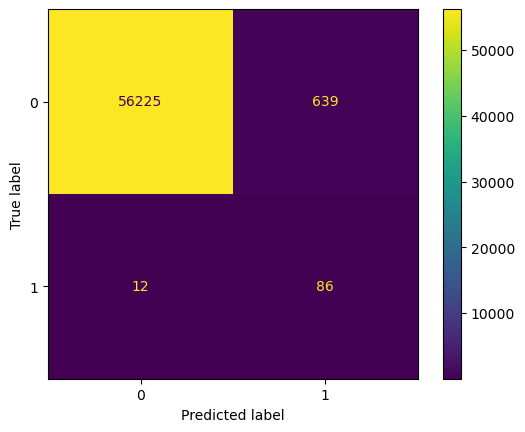

In [45]:
model_adasmt, recall_adasmt, f1_score_adasmt, accuracy_adasmt, roc_auc_adasmt, pr_auc_adasmt, tt_adasmt = run_model(model_ada, X_train_smt, y_train_smt, X_test, y_test)

## SVC

In [57]:
model1 = SVC(C= 10, kernel= 'rbf', random_state= 0)
model1.fit(X_train, y_train)
y_pred_svm = model1.predict(X_test)
print("Accuracy :",metrics.accuracy_score(y_test, y_pred_svm))
print("Precision:",metrics.precision_score(y_test, y_pred_svm))
print("Recall:",metrics.recall_score(y_test, y_pred_svm))
print("F1 Score:",metrics.f1_score(y_test, y_pred_svm))

roc_auc = roc_auc_score(y_test, y_pred_svm)
print("ROC-AUC:", roc_auc)

pr_auc = average_precision_score(y_test, y_pred_svm)
print("PR AUC:", pr_auc)

print("Classification Report:")
print(classification_report(y_test, y_pred_svm))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))


Accuracy : 0.999420666409185
Precision: 0.9710144927536232
Recall: 0.6836734693877551
F1 Score: 0.8023952095808383
ROC-AUC: 0.8418191488750817
PR AUC: 0.6644010695507596
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.97      0.68      0.80        98

    accuracy                           1.00     56962
   macro avg       0.99      0.84      0.90     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
[[56862     2]
 [   31    67]]


## SVC + SMOTE

In [ ]:
model2 = SVC(C= 10, kernel= 'rbf', random_state= 0)
model2.fit(X_train_smt, y_train_smt)
y_pred_svm = model2.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_svm))
print("Precision:",metrics.precision_score(y_test, y_pred_svm))
print("Recall:",metrics.recall_score(y_test, y_pred_svm))
print("F1 Score: ",metrics.f1_score(y_test, y_pred_svm))

roc_auc = roc_auc_score(y_test, y_pred_svm)
print("ROC-AUC:", roc_auc)

pr_auc = average_precision_score(y_test, y_pred_svm)
print("PR AUC:", pr_auc)

print("Classification Report:")
print(classification_report(y_test, y_pred_svm))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

## Model Selection (SMOTE)

In [ ]:
#accuracy_scores = [accuracy_score(y_test, y_pred_svm),accuracy_lrsmt, accuracy_rfsmt, accuracy_lgbsmt, accuracy_knn, accuracy_dtsmt, accuracy_xgbsmt, accuracy_cbsmt, accuracy_adasmt]
#roc_auc_scores = [roc_auc_lrsmt, roc_auc_rfsmt, roc_auc_lgbsmt, roc_auc_knn, roc_auc_dtsmt, roc_auc_xgbsmt, roc_auc_cbsmt, roc_auc_adasmt]
f1_scores = [f1_score(y_test, y_pred_svm),f1_score_lrsmt, f1_score_rfsmt, f1_score_lgbsmt, f1_score_knnsmt, f1_score_dtsmt, f1_score_xgbsmt, f1_score_cbsmt, f1_score_adasmt]
recall = [recall_score(y_test, y_pred_svm),recall_lrsmt, recall_rfsmt, recall_lgbsmt, recall_knnsmt, recall_dtsmt, recall_xgbsmt, recall_cbsmt, recall_adasmt]
#tt = [tt_svcsmt,tt_lrsmt, tt_rfsmt, tt_lgbsmt, tt_knn, tt_dtsmt, tt_xgbsmt, tt_cbsmt, tt_adasmt]

model_data = {'Model': ['SVC','Logistic Regression','Random Forest','LightGBM','KNN', 'Decision Tree', 'XGBoost', 'CatBoost', 'AdaBoost'],
              #'Accuracy': accuracy_scores,
              'Recall': recall,
              'F1 Score': f1_scores
             }
              #'Time taken': tt}
data = pd.DataFrame(model_data)

fig, ax = plt.subplots(figsize=(12, 8))

# Plot Recall
sns.barplot(x='Model', y='Recall', data=data, ax=ax, color='skyblue', label='Recall')

# Plot F1-Score
sns.barplot(x='Model', y='F1 Score', data=data, ax=ax, color='salmon', label='F1 Score')

ax.set_title('Model Comparison: Recall and F1-Score', fontsize=13)
ax.set_xlabel('Model', fontsize=13)
ax.set_ylabel('Scores', fontsize=13)
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Mô hình Random Forest mang lại kết quả tốt nhất với chỉ số F1_score, nhưng thời gian huấn luyện dài và tốn nhiều tài nguyên tính toán. Do đó chúng ta sẽ chọn mô hình LightGBM để tinh chỉnh và tối ưu hóa.

## Fine Tuning (Optuna)

In [ ]:
import optuna  # pip install optuna
import lightgbm as lgb
from sklearn.metrics import make_scorer

def objective(trial, X_train_smt, y_train_smt):
    max_depth=trial.suggest_int('max_depth',2,14)
    param_grid = {
        #         "device_type": trial.suggest_categorical("device_type", ['gpu']),
        #"n_estimators": trial.suggest_categorical("n_estimators", 1,300 ),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 4, 2**max_depth),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 500),
        "max_bin": trial.suggest_int("max_bin", 10, 300),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95, step=0.1)
    }


    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    model = lgb.LGBMClassifier(**param_grid)
    model.fit(X_train_smt,y_train_smt)
    scores = cross_val_score(model, X_train_smt, y_train_smt,
                             scoring=make_scorer(f1_score, average='weighted', labels=[1]),cv=cv, n_jobs=-1)
    return np.mean(scores)

### Luyện với nhiều trial để tìm ra hyperparameter tốt nhất

In [ ]:
study = optuna.create_study(direction='maximize')
func = lambda trial: objective(trial, X_train_smt, y_train_smt)
study.optimize(func, n_trials=100)

### In ra hyperparamater tốt nhất

In [ ]:
print(f"\tBest value (Accuracy): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

### Thế vào mô hình + Kết quả sau khi chạy

In [ ]:
param_lgb = {'max_depth': 7,
		'learning_rate': 0.19951544324247786,
		'num_leaves': 111,
		'min_data_in_leaf': 400,
		'max_bin': 283,
		'lambda_l1': 0,
		'lambda_l2': 15,
		'min_gain_to_split': 0.28933800810714827,
		'bagging_fraction': 0.9,
		'bagging_freq': 1,
		'feature_fraction':  0.30000000000000004
}

lgb_opt = lgb.LGBMClassifier(**param_lgb)
run_model(lgb_opt, X_train_smt, y_train_smt, X_test, y_test)